In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import timm

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

In [2]:
class LeavesDataset(torch.utils.data.Dataset):
    def __init__(self, transforms, path="../data/A1"):
        self.path = path
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = [x for x in os.listdir(path) if x.endswith("_rgb.png")]
        self.masks = [x for x in os.listdir(path) if x.endswith("_label.png")]
        self.cnt = 0

    def __getitem__(self, idx):
        # load images and masks
        img_path = self.path + "/" + self.imgs[idx]
        mask_path = self.path + "/" + self.masks[idx]
        img = read_image(img_path,ImageReadMode.RGB)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        # check boxes area is not zero
        boxes = boxes[area > 0]
        labels = labels[area > 0]
        masks = masks[area > 0]
        area = area[area > 0]
        iscrowd = np.zeros((len(boxes),), dtype=np.int64)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        if self.cnt == 0:
            print(img.shape)
            self.cnt += 1
            
        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (leaves) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [4]:
# m = torchvision.models.swin_v2_t().features
# test_input = torch.rand(1, 3, 224, 224)
# test_output = m(test_input)
# test_output.shape # torch.Size([1, 7, 7, 768])

In [18]:
timm.list_models("*large*")

['beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_large_patch16_224',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnextv2_large',
 'davit_large',
 'deit3_large_patch16_224',
 'deit3_large_patch16_384',
 'eva02_large_patch14_224',
 'eva02_large_patch14_448',
 'eva02_large_patch14_clip_224',
 'eva02_large_patch14_clip_336',
 'eva_large_patch14_196',
 'eva_large_patch14_336',
 'flexivit_large',
 'focalnet_large_fl3',
 'focalnet_large_fl4',
 'focalnet_xlarge_fl3',
 'focalnet_xlarge_fl4',
 'hiera_large_224',
 'maxvit_large_tf_224',
 'maxvit_large_tf_384',
 'maxvit_large_tf_512',
 'maxvit_xlarge_tf_224',
 'maxvit_xlarge_tf_384',
 'maxvit_xlarge_tf_512',
 'maxxvitv2_rmlp_large_rw_224',
 'mobilenetv3_large_075',
 'mobilenetv3_large_100',
 'mvitv2_large',
 'mvitv2_large_cls',
 'nasnetalarge',
 'nextvit_large',
 'pnasnet5large',
 'samvit_large_patch16',
 'swin_large_patch4_window7_224',
 'swin_large_patch4_window

In [20]:
timm.create_model("eva02_large_patch14_224", features_only=True)(torch.rand(1, 3, 224, 224))[0].shape

torch.Size([1, 1024, 16, 16])

In [7]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = timm.create_model("eva02_large_patch14_224", features_only=True)
        
    def forward(self, x):
        return self.model(x)[0]

In [8]:
MyModel()(torch.rand(1, 3, 224, 224)).shape

torch.Size([1, 768, 7, 7])

In [9]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
# backbone = torchvision.models.mobilenet_v3_small().features
backbone = MyModel()
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v3_small, it's 576
# so we need to add it here
backbone.out_channels = 1024

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn()

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [11]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [12]:
import utils


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = LeavesDataset(get_transform(train=True), path="../data/A1")
data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]


torch.Size([3, 530, 500])


In [13]:
targets[0]

{'boxes': tensor([[290., 250., 331., 280.],
         [223., 126., 278., 219.],
         [231., 213., 268., 246.],
         [186., 226., 256., 276.],
         [268., 237., 297., 261.],
         [264., 220., 280., 244.],
         [285., 269., 364., 343.],
         [243., 244., 284., 287.],
         [278., 191., 331., 234.],
         [222., 284., 266., 337.],
         [291., 195., 400., 239.],
         [159., 184., 231., 233.],
         [293., 227., 388., 264.],
         [273., 105., 331., 225.]]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  .

In [14]:
output = model(images, targets)  # Returns losses and detections
print(output)

{'loss_classifier': tensor(4.1131, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.6617, grad_fn=<DivBackward0>), 'loss_objectness': tensor(1.2020, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0732, grad_fn=<DivBackward0>)}


In [15]:
# For inference
model.eval()
x = [torch.rand(3, 224, 224), torch.rand(3, 224, 224)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [16]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = LeavesDataset(get_transform(train=True))
dataset_test = LeavesDataset(get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-10])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-10:])

# define training and validation data loaders
data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

torch.Size([3, 530, 500])
Epoch: [0]  [ 0/59]  eta: 0:00:48  lr: 0.000091  loss: 4.3161 (4.3161)  loss_classifier: 0.6681 (0.6681)  loss_box_reg: 0.0826 (0.0826)  loss_mask: 2.7643 (2.7643)  loss_objectness: 0.7000 (0.7000)  loss_rpn_box_reg: 0.1010 (0.1010)  time: 0.8253  data: 0.0300  max mem: 1773
Epoch: [0]  [10/59]  eta: 0:00:20  lr: 0.000952  loss: 2.5176 (2.7766)  loss_classifier: 0.6094 (0.5915)  loss_box_reg: 0.0335 (0.0497)  loss_mask: 1.0981 (1.3350)  loss_objectness: 0.6982 (0.6983)  loss_rpn_box_reg: 0.0927 (0.1021)  time: 0.4178  data: 0.0381  max mem: 1942
Epoch: [0]  [20/59]  eta: 0:00:15  lr: 0.001814  loss: 1.9221 (2.2719)  loss_classifier: 0.4284 (0.4341)  loss_box_reg: 0.0069 (0.0305)  loss_mask: 0.7135 (1.0076)  loss_objectness: 0.6947 (0.6940)  loss_rpn_box_reg: 0.0991 (0.1057)  time: 0.3726  data: 0.0369  max mem: 1942
Epoch: [0]  [30/59]  eta: 0:00:11  lr: 0.002675  loss: 1.7143 (2.1515)  loss_classifier: 0.2453 (0.3929)  loss_box_reg: 0.0323 (0.1219)  loss_mask

torch.Size([12])
torch.Size([76, 530, 500])


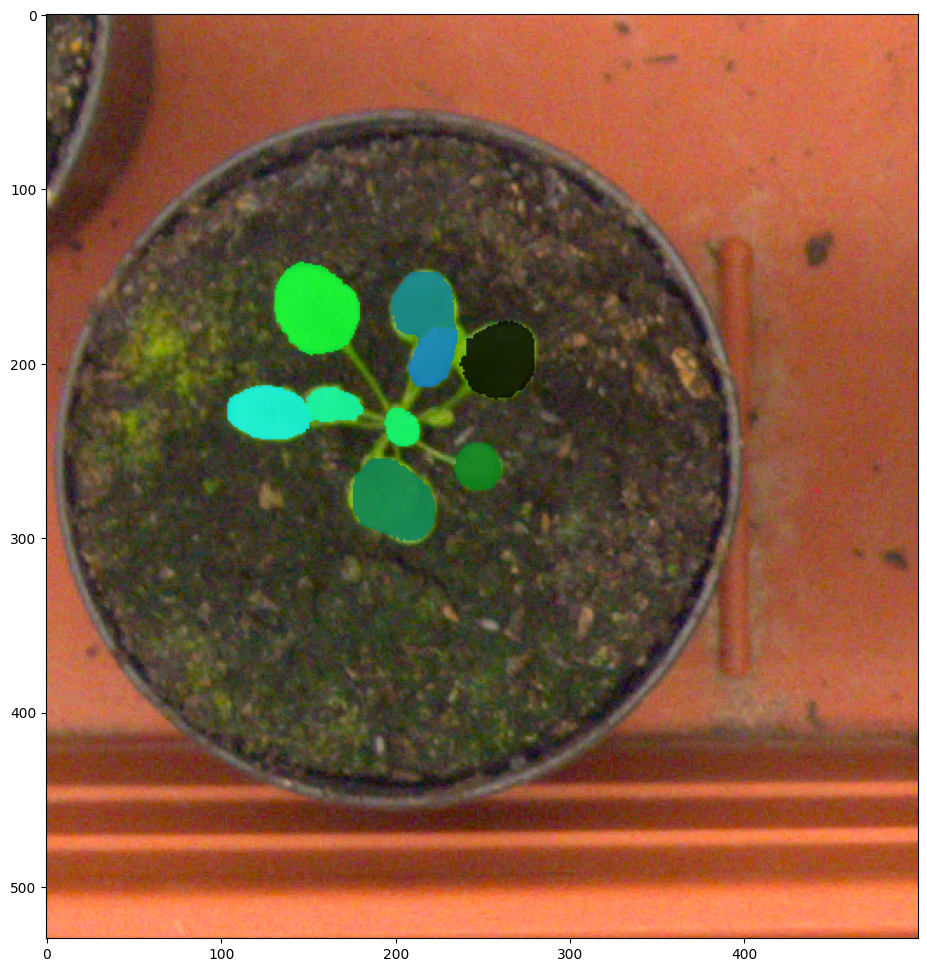

In [17]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("../data/A1/plant002_rgb.png", ImageReadMode.RGB)
labels = read_image("../data/A1/plant002_label.png")
labels_unique = torch.unique(labels)
print(labels_unique.shape)
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

masks = (pred["masks"] > 0.7).squeeze(1)
print(masks.shape)
image = draw_segmentation_masks(image, masks[:labels_unique.shape[0]-3])


plt.figure(figsize=(12, 12))
plt.imshow(image.permute(1, 2, 0))